# Google Driveのマウント

In [1]:
# from google.colab import drive
# from pathlib import Path

# drive.mount("/drive")
# drive_dir = Path("/drive")

# 5.2.1

In [2]:
data = [{ "from": "human", "value": "冷たいシャワーを毎日浴びることの長所と短所について、短いパラグラフを書いてください。" }, { "from": "gpt", "value": "冷たいシャワーを毎日浴びることのメリットは、注意力を高め、気分を高揚させること、健康全般を改善すること、ガスや電気を使ってお湯を沸かさないので光熱費の節約になることです。一方、冷たいシャワーはあまり歓迎されるものではありません。特に寒い冬には、冷たいシャワーに浸かるという精神的な障壁を超えられず、失敗や失望を考えてしまうかもしれません。" }]
prompt_template = "{from}: {value}"
instruction_text = ""
for d in data[:-1]:
    instruction_text += prompt_template.format(**d)
response_text = prompt_template.format(**data[-1])

print(instruction_text)
print(response_text)

human: 冷たいシャワーを毎日浴びることの長所と短所について、短いパラグラフを書いてください。
gpt: 冷たいシャワーを毎日浴びることのメリットは、注意力を高め、気分を高揚させること、健康全般を改善すること、ガスや電気を使ってお湯を沸かさないので光熱費の節約になることです。一方、冷たいシャワーはあまり歓迎されるものではありません。特に寒い冬には、冷たいシャワーに浸かるという精神的な障壁を超えられず、失敗や失望を考えてしまうかもしれません。


# 5.2.2

In [3]:
import os
from datasets import load_dataset

# キャッシュディレクトリをユーザーのホームディレクトリに設定
cache_dir = os.path.expanduser("~/hf_datasets_cache")
os.makedirs(cache_dir, exist_ok=True)
os.environ['HF_DATASETS_CACHE'] = cache_dir

ds = load_dataset("databricks/databricks-dolly-15k", cache_dir=cache_dir)
print(ds["train"]) 
# Dataset({
#     features: ['instruction', 'context', 'response', 'category'],
#     num_rows: 15011
# })

Dataset({
    features: ['instruction', 'context', 'response', 'category'],
    num_rows: 15011
})


In [4]:
ds_train = ds["train"].filter(lambda x: x["context"] == "")
print(ds_train.num_rows) # 10544

10544


In [5]:
prompt_template = """\
### Question: {instruction}
### Answer: {response}{eos_token}"""

def format_input(example):
    texts = []
    for instruction, response in zip(example['instruction'], example['response']):
        text = prompt_template.format(instruction=instruction, response=response, eos_token=tokenizer.eos_token)
        texts.append(text)
    return texts

In [6]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
)
tokenizer.pad_token = tokenizer.eos_token

/home/fubuki-sawa/CSU-proj/book-llm-from-scratch/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/fubuki-sawa/CSU-proj/book-llm-from-scratch/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Token indices sequence length is longer than the specified maximum sequence length for this model (1040 > 1024). Running this sequence through the model will result in indexing errors


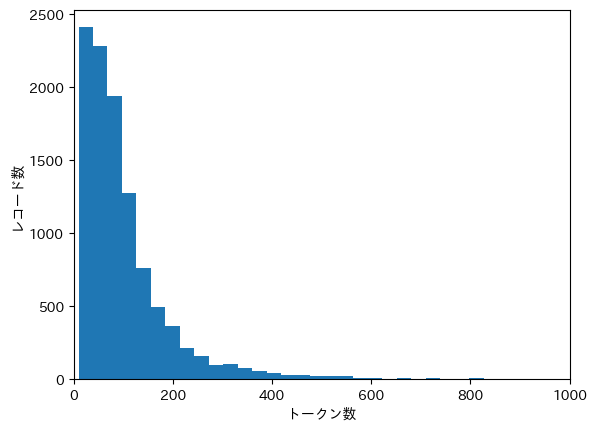

In [7]:
import matplotlib.pyplot as plt
import japanize_matplotlib

fig, ax = plt.subplots()

lengths = [len(tokenizer.encode(text)) for text in format_input(ds_train)]
ax.hist(lengths, bins=200)
ax.set_xlim(0, 1000)
ax.set_xlabel("トークン数")
ax.set_ylabel("レコード数")
fig.savefig("histogram.png", dpi=300, bbox_inches="tight")

In [8]:
max_length = 512

ds_train = ds_train.filter(lambda x: len(tokenizer.encode(prompt_template.format(instruction=x["instruction"], response=x["response"], eos_token=tokenizer.eos_token))) <= max_length)
print(ds_train.num_rows) # 10400

10400


In [9]:
import torch

prompt_template = """\
### Question: {instruction}
### Answer: """
response_template = "### Answer:"

@torch.inference_mode
def inference(model, tokenizer, user_input):
    prompt = prompt_template.format(instruction=user_input)

    # トークン化
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(model.device)

    # モデルで生成
    output = model.generate(
        input_ids,
        max_new_tokens=128,
        do_sample=False,
        repetition_penalty=1.1,
        pad_token_id=tokenizer.eos_token_id
    )

    # 生成されたテキストをデコード
    generated_text = tokenizer.decode(output[0], skip_special_tokens=False)
    
    # プロンプト部分を除去して応答部分のみを取得
    prompt_length = len(tokenizer.decode(input_ids[0], skip_special_tokens=False))
    response = generated_text[prompt_length:].strip()
    
    # EOSトークンがある場合は除去
    if tokenizer.eos_token in response:
        response = response.replace(tokenizer.eos_token, "").strip()
    
    return response

In [10]:
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM
from transformers import TrainingArguments

collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

config = TrainingArguments(
    output_dir='./output',
    save_strategy="no",
    save_total_limit=1,
    logging_steps=10,
    max_steps=50,  
    per_device_train_batch_size=8,
    lr_scheduler_type="constant",
    learning_rate=1e-6,
    remove_unused_columns=False,
)


trainer = SFTTrainer(
    model,
    args=config,
    train_dataset=ds_train,
    formatting_func=format_input,
    data_collator=collator,
    max_seq_length=max_length,
)

/home/fubuki-sawa/CSU-proj/book-llm-from-scratch/.venv/lib/python3.11/site-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(
/home/fubuki-sawa/CSU-proj/book-llm-from-scratch/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Using pad_token, but it is not set yet.


In [11]:
trainer.train()

/home/fubuki-sawa/CSU-proj/book-llm-from-scratch/.venv/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
10,5.821200
20,5.164500
30,4.227500
40,3.570600
50,2.916300


TrainOutput(global_step=50, training_loss=4.340004501342773, metrics={'train_runtime': 2.2784, 'train_samples_per_second': 175.559, 'train_steps_per_second': 21.945, 'total_flos': 10472094720000.0, 'train_loss': 4.340004501342773, 'epoch': 0.04})

In [12]:
print("=== 学習後の推論（英語の質問） ===")
after_training_response = inference(model, tokenizer, "What is the capital of Japan?")
print(f"質問: What is the capital of Japan?")
print(f"回答: {after_training_response}")

=== 学習後の推論（英語の質問） ===
質問: What is the capital of Japan?
回答: I am a Japanese citizen. I have been in this country for over 2 years and it has always seemed like there was something wrong with my life, but now that's not true anymore! It seems to be getting more difficult because you can't get out from your home or even go back into school so why would they want me here?! So what do we need as an adult if our lives are going well then how about us being able to live happily ever after!! (This question comes up often on social media) Reply Delete
The answer will come down soon... The reason behind all these questions coming at once when people ask them
